In [70]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import tensorflow as tf
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.python.client import device_lib
device_lib.list_local_devices()
tf.test.is_gpu_available()



urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")



total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])



total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)



total_data.drop_duplicates(subset=['reviews'], inplace=True)



# 훈련 데이터와 테스트 데이터를 3:1 비율로 분리
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)



# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)



# 중복 제거
test_data.drop_duplicates(subset = ['reviews'], inplace=True) 
# 정규 표현식 수행
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 
# 공백은 Null 값으로 변경
test_data['reviews'].replace('', np.nan, inplace=True) 
# Null 값 제거
test_data = test_data.dropna(how='any') 



from eunjeon import Mecab
mecab = Mecab()



stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']



train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])



X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values



# 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 텍스트 데이터에 정수 인코딩 수행

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)



# 단어 집합이 생성되는 동시에 각 단어에 고유한 정수 부여
# 등장 횟수가 1회인 단어들은 자연어 처리에서 배제

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)



# 단어 집합 크기를 토크나이저의 인자로 넘겨주고, 텍스트 시퀀스를 정수 시퀀스로 변환
# 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환

# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)



tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)



# 패딩
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 작업

def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))



max_len = 80
below_threshold_len(max_len, X_train)



# 훈련용 리뷰의 99.99가 80이하의 길이를 가지기 때문에, 훈련용 리뷰를 길이 80으로 패딩

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)



# GRU로 네이버 쇼핑 리뷰 감성 분류

from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)



loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))



def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    return 1
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))
    return 0



sentiment_predict("불친절")

C:\Users\jeonj\AppData\Local\Temp\ipykernel_3636\3858855300.py:44: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\jeonj\AppData\Local\Temp\ipykernel_3636\3858855300.py:52: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


단어 집합(vocabulary)의 크기 : 39741
등장 빈도가 1번 이하인 희귀 단어의 수: 18056
단어 집합에서 희귀 단어의 비율: 45.43418635665937
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7869324583053495
단어 집합의 크기 : 21687
전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553
Epoch 1/15
1872/1875 [============================>.] - ETA: 0s - loss: 0.2724 - acc: 0.8961
Epoch 1: val_acc improved from -inf to 0.91466, saving model to best_model.h5
1875/1875 [==============================] - 35s 17ms/step - loss: 0.2724 - acc: 0.8961 - val_loss: 0.2353 - val_acc: 0.9147
Epoch 2/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.2152 - acc: 0.9223
Epoch 2: val_acc improved from 0.91466 to 0.92143, saving model to best_model.h5
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2152 - acc: 0.9223 - val_loss: 0.2177 - val_acc: 0.9214
Epoch 3/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.1983 - acc: 0.9289
Epoch 3: val_acc improved from 0.92143 to 0.92567, saving model to best_model.h5
1875/1875 [==============

0

In [71]:
data1 = pd.read_csv('goodnara.csv')
data2 = pd.read_csv('drstyle.csv')
data3 = pd.read_csv('thecheaper.csv')
data=pd.concat([data1, data2, data3], ignore_index=True)
data=data.loc[:, ['comment', 'date', 'star', 'topic']].dropna()

In [72]:
data

,comment,date,star,topic
0,평소 볼캡을 안써서 흠뻑쇼에 쓰려고 급하게 주문했는데 배송 빠르고 모자가 커서 신랑...,2022-07-26,5,smartstore.goodnara.review
1,남편 워터파크 갈때 쓸 모자 샀어요 집에있는 모자가 프리사이즈이고 안에 설명되어있는...,2022-07-10,3,smartstore.goodnara.review
2,사이즈나 디자인은 너무 맘에 드는데 앞에서 보면 모자가 둥글지 않고 옆에 약간 뾰족...,2022-07-22,3,smartstore.goodnara.review
3,지난번 구입후 사용감도 좋고\n편안하고 디자인도 깔끔해서\n재구매했습니다.\n좋은 ...,2022-07-19,5,smartstore.goodnara.review
4,너무 좋아요. 대두라서 모자 찾기 힘든데,2022-07-10,5,smartstore.goodnara.review
...,...,...,...,...
19547,조아요 예브네요ㅇㅇ,2019-04-07,5,smartstore.thecheaper.review
19548,흰색 모자 쓰다가 잃어버려서 새로 샀는데 좋아요,2019-03-28,5,smartstore.thecheaper.review
19549,좋아요. 제품배송도 빠르고 저렴해서 맘에듭니다,2019-03-18,4,smartstore.thecheaper.review
19550,아니 리뷰가 너무 좋습니다~~,2019-04-02,5,smartstore.thecheaper.review


In [77]:
data['label'] = np.select([data.star > 3], ['긍정'], default='부정')

In [78]:
data['new_label']=None

In [94]:
for i in range(len(data['comment'])):
    if sentiment_predict(data['comment'][i]) == 1:
        data['new_label'][i] = '긍정'
    else:
        data['new_label'][i] = '부정'

1/1 [==============================] - 0s 25ms/step
88.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.51% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step


C:\Users\jeonj\AppData\Local\Temp\ipykernel_3636\3767062690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][i] = '긍정'
C:\Users\jeonj\AppData\Local\Temp\ipykernel_3636\3767062690.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][i] = '부정'


96.06% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
99.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.97% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.22% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
99.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
78.08% 확률로 부정 리뷰입니다.
1/1 [=========================

1/1 [==============================] - 0s 18ms/step
98.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
84.79% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
80.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
97.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
97.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
88.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
68.22% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
92.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
76.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
85.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
62.58% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
52.72% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
83.43% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
56.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.89% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
97.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.42% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
63.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
88.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
99.70% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.04% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
82.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
79.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
85.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
98.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
86.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
68.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.23% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
89.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
86.36% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
82.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
82.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
82.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
89.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.05% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 19ms/step
90.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
91.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
80.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
70.29% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
81.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 18ms/step
76.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
90.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.08% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
90.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 19ms/step
51.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
84.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.21% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
72.93% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
87.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
58.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
58.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
91.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step
99.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
99.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
76.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
79.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
94.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 18ms/step
99.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.56% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
95.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
67.69% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
76.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.02% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
98.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
87.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
79.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
71.17% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 20ms/step
98.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
56.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
89.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
57.31% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
57.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.71% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 21ms/step
95.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
94.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
82.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.25% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 16ms/step
99.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.21% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
83.94% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
95.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
82.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
73.22% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
82.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
65.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
82.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 18ms/step
97.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
87.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
61.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.33% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
98.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
77.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
53.10% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
75.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
97.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
91.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
92.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
78.91% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 20ms/step
95.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
58.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
71.63% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
66.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
98.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
81.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
71.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
90.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
96.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
77.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
95.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
89.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 20ms/step
93.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
89.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 18ms/step
65.76% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
78.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
78.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 19ms/step
98.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
84.41% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
92.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
64.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
65.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
60.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
70.40% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
71.55% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 18ms/step
98.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
58.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.93% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
56.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.22% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
71.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
85.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
90.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.04% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
69.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
88.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
84.36% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
90.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
90.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 19ms/step
82.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
93.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
92.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.62% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 18ms/step
99.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
99.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
85.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
72.93% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 17ms/step
98.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
73.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.20% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.19% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
91.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
65.68% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
65.68% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
95.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.48% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
84.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
76.26% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
84.18% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
78.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 17ms/step
83.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
69.81% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
86.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
90.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
72.39% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
50.56% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.52% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.52% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 20ms/step
98.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
68.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.06% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
92.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.33% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 21ms/step
97.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
85.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
73.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
73.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 19ms/step
97.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
56.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
95.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
72.56% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
69.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
76.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.90% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 27ms/step
83.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 17ms/step
83.56% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
83.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
81.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
88.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
82.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
92.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
50.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 20ms/step
53.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
73.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
97.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.51% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.51% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.51% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.10% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 18ms/step
82.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
79.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
83.36% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
93.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
96.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
82.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
99.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
55.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
55.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
54.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
54.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
97.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
83.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
83.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.85% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
97.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
93.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
67.54% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 20ms/step
91.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
80.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
80.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
83.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
63.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
94.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.12% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
90.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 17ms/step
95.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
84.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
90.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
57.54% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
99.11% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
87.83% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
81.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
83.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 22ms/step
86.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
94.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
86.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
84.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
90.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.86% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
65.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
88.87% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
85.41% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
74.83% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
94.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 22ms/step
63.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
95.65% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.36% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
72.93% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 21ms/step
93.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.13% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.13% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
72.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
72.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
58.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
84.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
99.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
97.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
80.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
65.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
86.95% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
98.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
95.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
91.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
72.93% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step
97.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
70.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.41% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.31% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
84.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
84.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 21ms/step
91.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
86.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
95.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
85.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
85.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
71.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
71.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
92.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.32% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
79.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
79.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
75.36% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
73.13% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
93.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 21ms/step
97.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
79.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
79.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
79.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
73.39% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
54.87% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 19ms/step
97.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
97.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
91.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 28ms/step
97.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
82.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
97.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
91.83% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
78.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
78.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
95.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 20ms/step
72.93% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
89.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
84.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 21ms/step
97.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step
98.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
94.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 28ms/step
98.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step
98.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
98.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 20ms/step
55.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
60.38% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
79.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
79.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
84.21% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
94.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
84.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 20ms/step
96.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.27% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
77.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
77.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
64.28% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
82.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
74.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 18ms/step
96.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
73.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
73.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
73.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
86.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
53.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.39% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 18ms/step
88.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.13% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
73.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
56.37% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
69.95% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
78.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
78.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 20ms/step
99.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
75.31% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.45% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
79.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
51.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
51.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
93.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
90.75% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 21ms/step
89.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
59.77% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
84.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
79.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
84.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
95.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.96% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
85.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step
97.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
82.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
50.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
92.92% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.99% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step
98.51% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.15% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.93% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
92.93% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
78.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
83.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
50.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
87.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
85.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
83.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 20ms/step
80.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
66.78% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
90.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
68.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
68.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
68.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
54.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
63.17% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.32% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
93.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
73.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
88.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
81.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
77.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
92.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.42% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
67.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
87.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 19ms/step
66.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
88.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
88.66% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
59.09% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
61.41% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.24% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 24ms/step
93.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
90.87% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
92.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
92.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
75.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
82.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 28ms/step
73.12% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
78.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
78.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
61.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
64.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
61.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
71.01% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.34% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
77.76% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 18ms/step
85.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
91.38% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
78.37% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 21ms/step
71.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
80.39% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
69.09% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.08% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 20ms/step
98.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
94.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.72% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
83.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
90.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
89.17% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
82.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
82.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 21ms/step
99.48% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.48% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
78.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
78.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
84.49% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
98.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
95.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
95.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
84.93% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
84.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
90.62% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
90.62% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
90.62% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
89.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
94.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step
92.10% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
61.52% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
95.65% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
93.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.16% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
93.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
89.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
89.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
93.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
84.91% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
59.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
99.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
90.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
93.80% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
94.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
94.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
80.69% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
80.69% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
79.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
82.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 19ms/step
96.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
72.19% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
92.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
78.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
84.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.97% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
78.95% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
89.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
59.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
88.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 18ms/step
98.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
81.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.26% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.97% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
90.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
89.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
97.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 22ms/step
98.18% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
86.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.36% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
73.46% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
73.46% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
73.46% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
98.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
91.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step
95.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
93.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
72.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 20ms/step
97.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.47% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
68.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
94.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.73% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.97% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
59.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 18ms/step
95.00% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
90.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
86.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
86.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
62.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
86.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
68.41% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
67.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
94.97% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
72.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
72.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
67.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
76.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.64% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
92.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
67.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
97.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 20ms/step
51.02% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
70.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.84% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
63.96% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.10% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.10% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.09% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
87.17% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.63% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 24ms/step
98.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step
99.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
99.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
99.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 30ms/step
69.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 28ms/step
69.50% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
88.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 27ms/step
95.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
95.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 26ms/step
63.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
97.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 20ms/step
89.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
94.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.74% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
87.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
95.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
95.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
95.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 23ms/step
95.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.28% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
73.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
93.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
83.89% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
91.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
96.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
71.74% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
95.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
95.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
73.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 21ms/step
95.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
97.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
94.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.05% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.43% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
95.35% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
99.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.04% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
78.45% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
78.45% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 18ms/step
98.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
65.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
92.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.57% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
88.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
86.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.54% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.54% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 18ms/step
55.40% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
91.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
76.46% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
76.46% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
91.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
73.50% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 21ms/step
98.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
93.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
64.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
73.71% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
86.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.03% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 19ms/step
97.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.31% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
85.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
59.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.61% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step
93.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
98.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
64.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
82.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
88.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
57.20% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
64.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
86.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.77% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
67.18% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.90% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.89% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.31% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
88.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
73.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
73.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
73.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
73.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
73.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.49% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step
91.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
87.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
79.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 28ms/step
98.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
98.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 32ms/step
96.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
92.93% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
86.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
97.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 18ms/step
94.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.87% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
95.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
88.06% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
73.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
74.98% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
99.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
78.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step
54.33% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
72.74% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
68.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
96.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
60.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
60.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
92.13% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
90.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
75.29% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 37ms/step
86.93% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
69.49% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
81.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
90.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
83.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 43ms/step
63.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
70.64% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
80.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
69.48% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 18ms/step
79.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
79.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
82.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
79.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
79.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
88.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
88.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.50% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
53.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 42ms/step
74.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
95.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.33% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
79.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.77% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
82.14% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
51.77% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 20ms/step
98.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.54% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
63.73% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
85.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
96.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
90.90% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
87.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
79.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 28ms/step
96.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
96.74% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
75.10% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
66.84% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.64% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
96.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.76% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.31% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.51% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.67% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 42ms/step
94.69% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
81.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
78.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.48% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.36% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
96.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
60.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.86% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.47% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
64.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 18ms/step
97.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
67.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
98.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
84.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
76.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
84.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
84.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 18ms/step
92.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
78.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
83.21% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
84.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
78.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 39ms/step
78.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
78.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 39ms/step
94.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
81.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
92.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
87.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
61.60% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
95.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.39% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.32% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.32% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
94.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.14% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.91% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
72.93% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step
96.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
82.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
80.31% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.43% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
79.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
98.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
59.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.48% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
94.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
90.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 18ms/step
95.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
74.44% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
67.86% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
78.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
78.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step
96.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.68% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
81.86% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
85.28% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.83% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.42% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.42% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
98.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.92% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
82.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
82.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
92.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.07% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
86.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
73.60% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
88.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
84.70% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
84.81% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
87.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.05% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.72% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
65.25% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step
95.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
78.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
78.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.61% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.61% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
67.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
97.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
99.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 34ms/step
96.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
77.53% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.85% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
57.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
57.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
57.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
97.72% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
99.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 27ms/step
99.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
71.69% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
61.60% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
78.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.57% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
71.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
78.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 23ms/step
98.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
98.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
95.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step
84.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
70.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
70.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
70.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
76.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
86.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 19ms/step
99.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.64% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.66% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
89.59% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.66% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
92.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 27ms/step
87.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.95% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
87.94% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
83.80% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 20ms/step
72.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.56% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
86.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
93.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.98% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
91.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
63.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
52.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
63.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step
96.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
88.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
88.77% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
88.77% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
88.77% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.92% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.01% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step
91.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
91.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
98.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
82.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
82.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step
95.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
95.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
99.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
55.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
68.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step
90.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
90.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.92% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
82.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
88.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
93.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
86.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.73% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
82.91% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
70.26% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
71.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
71.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
98.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
91.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
52.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.86% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
69.09% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
79.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
95.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
59.09% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.22% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
87.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
86.89% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.19% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
83.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
87.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
94.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
78.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
95.10% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
82.77% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.08% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.55% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.10% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.38% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.54% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
86.04% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 19ms/step
74.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
90.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
59.95% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
63.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
86.38% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.52% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.92% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
86.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
85.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 21ms/step
99.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
72.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.00% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
50.96% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
52.63% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.38% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
92.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 20ms/step
99.61% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
77.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.55% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.47% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.11% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 21ms/step
88.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
53.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
50.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.54% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
88.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
88.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
88.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
85.10% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
98.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.73% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
99.84% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
78.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
52.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
86.68% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.44% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.10% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
86.68% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
86.68% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
86.68% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.29% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 18ms/step
72.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.48% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.48% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.94% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
77.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
77.46% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
85.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
83.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step
98.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.13% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
99.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
72.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
82.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.30% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
77.62% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.29% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
63.62% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
94.19% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.70% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.15% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
72.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
80.23% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.65% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
93.71% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
59.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 19ms/step
82.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 27ms/step
85.94% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
92.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
87.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.92% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
96.59% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
75.60% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
60.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
76.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
60.53% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
68.44% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 33ms/step
72.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
86.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.25% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
52.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
57.98% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step
85.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 18ms/step
98.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
79.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
82.63% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
55.93% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
99.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
89.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.50% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
94.96% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
73.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
94.37% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
91.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
98.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
94.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.57% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
92.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 24ms/step
92.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
92.82% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.86% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step
76.26% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.89% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
51.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
51.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
51.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
84.51% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
58.41% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step
90.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
90.96% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.09% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
86.74% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
69.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 25ms/step
98.56% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
69.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 41ms/step
82.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
76.49% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
64.75% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step
97.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
82.95% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
92.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
87.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
53.45% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
62.21% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
64.35% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.22% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
90.15% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
71.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 19ms/step
79.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
84.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.06% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
81.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
81.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
61.25% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.25% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
80.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.09% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
97.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.15% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
88.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.95% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
71.86% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
72.93% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
83.84% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 19ms/step
92.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.97% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
80.31% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
95.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
65.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.49% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
97.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
93.45% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
76.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
76.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
86.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
88.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
82.48% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 49ms/step
94.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
60.38% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
50.14% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.32% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.05% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
69.86% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 17ms/step
96.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
54.54% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
62.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
62.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
62.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
80.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 20ms/step
96.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.54% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
88.58% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
89.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.00% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.68% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 19ms/step
93.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.86% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
81.91% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
89.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
82.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
70.28% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.84% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.57% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
86.73% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 19ms/step
91.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.27% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
88.87% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
61.06% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
81.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.32% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
82.30% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.68% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 18ms/step
98.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
75.02% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.18% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
70.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
70.52% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
71.36% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
83.45% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
83.45% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
77.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
60.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
86.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
81.87% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.33% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 36ms/step
99.79% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
98.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 19ms/step
98.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
98.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
85.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
84.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
97.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
84.75% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.33% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.82% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
76.40% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
86.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
87.02% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step
99.09% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.49% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.49% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
99.49% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
97.56% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
95.04% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.67% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
76.89% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.98% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
72.93% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.61% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 23ms/step
98.72% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.26% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.34% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.11% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
68.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
68.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
68.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.49% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.31% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
88.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 21ms/step
97.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
91.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
97.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
96.36% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 28ms/step
76.44% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
92.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 23ms/step
93.24% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.10% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
92.43% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
71.24% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 20ms/step
95.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.20% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
94.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
87.76% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.71% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
86.17% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.85% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
99.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.65% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.12% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step
98.38% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
80.52% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.25% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.39% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.29% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.28% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
56.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.31% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
65.46% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.38% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.81% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 21ms/step
84.49% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
81.66% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
78.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
78.08% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
96.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
94.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.68% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
75.63% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 22ms/step
97.16% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
88.42% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
97.02% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
96.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.11% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 20ms/step
98.41% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.55% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
69.74% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
56.94% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
99.15% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.77% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
56.83% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
94.69% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
98.62% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
73.79% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
89.80% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.53% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 20ms/step
95.97% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.99% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
91.07% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 18ms/step
97.58% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
70.78% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.70% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 21ms/step
76.72% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
95.15% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
96.88% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
97.34% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step
95.03% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
98.50% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 20ms/step
93.03% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 19ms/step

In [95]:
data

,comment,date,star,topic,label,new_label
0,평소 볼캡을 안써서 흠뻑쇼에 쓰려고 급하게 주문했는데 배송 빠르고 모자가 커서 신랑...,2022-07-26,5,smartstore.goodnara.review,긍정,긍정
1,남편 워터파크 갈때 쓸 모자 샀어요 집에있는 모자가 프리사이즈이고 안에 설명되어있는...,2022-07-10,3,smartstore.goodnara.review,부정,부정
2,사이즈나 디자인은 너무 맘에 드는데 앞에서 보면 모자가 둥글지 않고 옆에 약간 뾰족...,2022-07-22,3,smartstore.goodnara.review,부정,부정
3,지난번 구입후 사용감도 좋고\n편안하고 디자인도 깔끔해서\n재구매했습니다.\n좋은 ...,2022-07-19,5,smartstore.goodnara.review,긍정,긍정
4,너무 좋아요. 대두라서 모자 찾기 힘든데,2022-07-10,5,smartstore.goodnara.review,긍정,긍정
...,...,...,...,...,...,...
19547,조아요 예브네요ㅇㅇ,2019-04-07,5,smartstore.thecheaper.review,긍정,긍정
19548,흰색 모자 쓰다가 잃어버려서 새로 샀는데 좋아요,2019-03-28,5,smartstore.thecheaper.review,긍정,긍정
19549,좋아요. 제품배송도 빠르고 저렴해서 맘에듭니다,2019-03-18,4,smartstore.thecheaper.review,긍정,긍정
19550,아니 리뷰가 너무 좋습니다~~,2019-04-02,5,smartstore.thecheaper.review,긍정,긍정


In [96]:
import collections
collections.Counter(data['label'])

Counter({'긍정': 17450, '부정': 2102})

In [97]:
collections.Counter(data['new_label'])

Counter({'긍정': 16277, '부정': 3275})

In [58]:
print('기존의 긍/부정 비율: '+str(round(collections.Counter(data['label'])[1]/(collections.Counter(data['label'])[1]+collections.Counter(data['label'])[-1]+collections.Counter(data['label'])[0])*100, 2))+'%')

기존의 긍/부정 비율: 89.25%


In [59]:
print('조정된 긍/부정 비율: '+str(round(collections.Counter(data['new_label'])[1]/(collections.Counter(data['new_label'])[1]+collections.Counter(data['new_label'])[-1]+collections.Counter(data['new_label'])[0])*100, 2))+'%')

조정된 긍/부정 비율: 82.29%


In [99]:
data.to_csv('jeonj.csv',encoding='utf-8-sig')

In [ ]:
from elasticsearch import Elasticsearch
def insertData():
    headers = {'Content-type': 'application/json'}
    es = Elasticsearch('http://43.200.44.17:9200', headers = headers)
    
    index="jeonj3"
    
    doc = {
        "date" : date

        #"@timestamp" : datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'
    }
    
    es.index(index="jeonj3", doc_type="_doc", body=doc)


In [ ]:
insertData()

In [118]:
data=a

In [119]:
data

,comment,date,star,topic,label,new_label
0,평소 볼캡을 안써서 흠뻑쇼에 쓰려고 급하게 주문했는데 배송 빠르고 모자가 커서 신랑...,2022-07-26,5,smartstore.goodnara.review,긍정,긍정
1,남편 워터파크 갈때 쓸 모자 샀어요 집에있는 모자가 프리사이즈이고 안에 설명되어있는...,2022-07-10,3,smartstore.goodnara.review,부정,부정
2,사이즈나 디자인은 너무 맘에 드는데 앞에서 보면 모자가 둥글지 않고 옆에 약간 뾰족...,2022-07-22,3,smartstore.goodnara.review,부정,부정
3,지난번 구입후 사용감도 좋고\n편안하고 디자인도 깔끔해서\n재구매했습니다.\n좋은 ...,2022-07-19,5,smartstore.goodnara.review,긍정,긍정
4,너무 좋아요. 대두라서 모자 찾기 힘든데,2022-07-10,5,smartstore.goodnara.review,긍정,긍정
...,...,...,...,...,...,...
19547,조아요 예브네요ㅇㅇ,2019-04-07,5,smartstore.thecheaper.review,긍정,긍정
19548,흰색 모자 쓰다가 잃어버려서 새로 샀는데 좋아요,2019-03-28,5,smartstore.thecheaper.review,긍정,긍정
19549,좋아요. 제품배송도 빠르고 저렴해서 맘에듭니다,2019-03-18,4,smartstore.thecheaper.review,긍정,긍정
19550,아니 리뷰가 너무 좋습니다~~,2019-04-02,5,smartstore.thecheaper.review,긍정,긍정


In [106]:
data['comment'][0]

'평소 볼캡을 안써서 흠뻑쇼에 쓰려고 급하게 주문했는데 배송 빠르고 모자가 커서 신랑도 저도 한 머리크기 하는데 얼굴이 작아보이는 효과까지 있네요. ㅋㅋ 만족합니다.'

In [107]:
mecab.nouns()

['평소',
 '캡',
 '쇼',
 '주문',
 '배송',
 '모자',
 '신랑',
 '저',
 '머리',
 '크기',
 '데',
 '얼굴',
 '효과',
 '만족']

In [114]:
for i in data['comment']:
    i = mecab.nouns(i)

In [120]:
data=data.loc[:, ['comment', 'date', 'star', 'topic', 'label', 'new_label']].dropna()

# 중복 제거
data.drop_duplicates(subset = ['comment'], inplace=True, ignore_index=True) 
# 정규 표현식 수행
data['comment'] = data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 
# 공백은 Null 값으로 변경
data['comment'].replace('', np.nan, inplace=True) 
# Null 값 제거
data = data.dropna(how='any')

stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

data=data.reset_index(drop=False)
data=data.loc[:, ['comment', 'date', 'star', 'topic', 'label', 'new_label']].dropna()

C:\Users\jeonj\AppData\Local\Temp\ipykernel_3636\1340779050.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data['comment'] = data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [121]:
data

,comment,date,star,topic,label,new_label
0,평소 볼캡을 안써서 흠뻑쇼에 쓰려고 급하게 주문했는데 배송 빠르고 모자가 커서 신랑...,2022-07-26,5,smartstore.goodnara.review,긍정,긍정
1,남편 워터파크 갈때 쓸 모자 샀어요 집에있는 모자가 프리사이즈이고 안에 설명되어있는...,2022-07-10,3,smartstore.goodnara.review,부정,부정
2,사이즈나 디자인은 너무 맘에 드는데 앞에서 보면 모자가 둥글지 않고 옆에 약간 뾰족...,2022-07-22,3,smartstore.goodnara.review,부정,부정
3,지난번 구입후 사용감도 좋고편안하고 디자인도 깔끔해서재구매했습니다좋은 제품 싸게사서...,2022-07-19,5,smartstore.goodnara.review,긍정,긍정
4,너무 좋아요 대두라서 모자 찾기 힘든데,2022-07-10,5,smartstore.goodnara.review,긍정,긍정
...,...,...,...,...,...,...
15139,조아요 예브네요ㅇㅇ,2019-04-07,5,smartstore.thecheaper.review,긍정,긍정
15140,흰색 모자 쓰다가 잃어버려서 새로 샀는데 좋아요,2019-03-28,5,smartstore.thecheaper.review,긍정,긍정
15141,좋아요 제품배송도 빠르고 저렴해서 맘에듭니다,2019-03-18,4,smartstore.thecheaper.review,긍정,긍정
15142,아니 리뷰가 너무 좋습니다,2019-04-02,5,smartstore.thecheaper.review,긍정,긍정


In [122]:
for i in range(len(data['comment'])):
    data['comment'][i] = mecab.nouns(data['comment'][i])

C:\Users\jeonj\AppData\Local\Temp\ipykernel_3636\684740107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['comment'][i] = mecab.nouns(data['comment'][i])


In [125]:
data['comment'][0]

['평소',
 '캡',
 '쇼',
 '주문',
 '배송',
 '모자',
 '신랑',
 '저',
 '머리',
 '크기',
 '데',
 '얼굴',
 '효과',
 '만족']

In [126]:
data

,comment,date,star,topic,label,new_label
0,"[평소, 캡, 쇼, 주문, 배송, 모자, 신랑, 저, 머리, 크기, 데, 얼굴, 효...",2022-07-26,5,smartstore.goodnara.review,긍정,긍정
1,"[남편, 워터, 파크, 때, 모자, 집, 모자, 프리, 사이즈, 안, 설명, 사이즈...",2022-07-10,3,smartstore.goodnara.review,부정,부정
2,"[사이즈, 디자인, 맘, 앞, 모자, 옆, 모양]",2022-07-22,3,smartstore.goodnara.review,부정,부정
3,"[지난번, 구입, 후, 사용, 편안, 디자인, 구매, 제품, 서비스, 번창]",2022-07-19,5,smartstore.goodnara.review,긍정,긍정
4,"[대두, 모자]",2022-07-10,5,smartstore.goodnara.review,긍정,긍정
...,...,...,...,...,...,...
15139,[조아],2019-04-07,5,smartstore.thecheaper.review,긍정,긍정
15140,"[흰색, 모자]",2019-03-28,5,smartstore.thecheaper.review,긍정,긍정
15141,"[제품, 배송, 맘]",2019-03-18,4,smartstore.thecheaper.review,긍정,긍정
15142,[리뷰],2019-04-02,5,smartstore.thecheaper.review,긍정,긍정


In [141]:
from elasticsearch import Elasticsearch
def insertData(comment, date, star, topic, label, new_label):
    headers = {'Content-type': 'application/json'}
    es = Elasticsearch('http://43.200.44.17:9200', headers = headers)
    
    index="analyzed_data"
    
    doc = {
        "Name": topic,
        "Star": star,
        "Date": date,
        "Word": comment,
        "Sentiment": label,
        "Adjustment-sentiment": new_label

        #"@timestamp" : datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'
    }
    
    es.index(index="analyzed_data", doc_type="_doc", body=doc)


In [148]:
for i in range(len(data)):
    insertData(data['comment'][i], data['date'][i], data['star'][i], data['topic'][i], data['label'][i], data['new_label'][i])

In [143]:
len(data)

15144

In [144]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         2168700   
                                                                 
 gru_2 (GRU)                 (None, 128)               88320     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,257,149
Trainable params: 2,257,149
Non-trainable params: 0
_________________________________________________________________


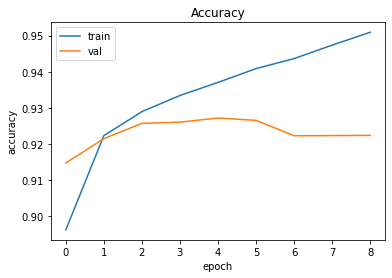

In [145]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

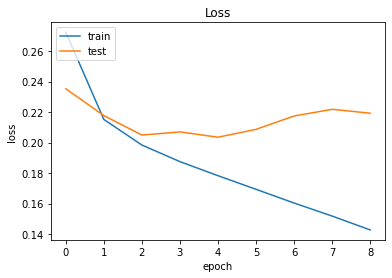

In [147]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()